In [3]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import utils

In [3]:
print(0.013, 0.002, 0.0, 0.002)

0.013 0.002 0.0 0.002


In [2]:
gdata = sc.read_h5ad('/home/wpy/stereoseq/20240502-SPACseq/RNA/Multitime.filtered.guide.bin100.h5')

In [3]:
gdata = utils.combine_guide_replicates(gdata)

/home/wpy/stereoseq/20240822-Pipeline/utils.py:88: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [38]:
cdf = pd.concat([pd.DataFrame(gdata.X, index=gdata.obs_names, columns=gdata.var_names), gdata.obs], axis=1)

/tmp/ipykernel_5833/1539675293.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = cdf.groupby('marker').sum().sum(axis=1).sort_index()
/tmp/ipykernel_5833/1539675293.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df, palette='rainbow', alpha=0.3)


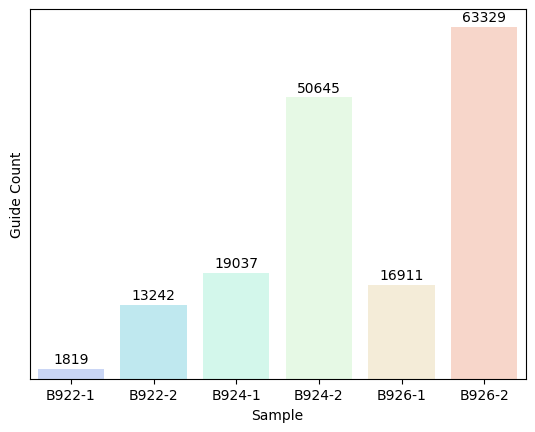

In [8]:
df = cdf.groupby('marker').sum().sum(axis=1).sort_index()
sns.barplot(df, palette='rainbow', alpha=0.3)
plt.ylabel('Guide Count')
plt.xlabel('Sample')
plt.yticks([])
for marker in df.index:
    plt.text(marker, df[marker] + 1000, df[marker], ha='center')
plt.show()

# Down Sample B926-1

In [39]:
pdata = gdata[gdata.obs.marker == 'B926-1'].copy()

entro_dict = {}
for ds_size in [0, 1000, 2000, 5000, 10000, 20000]:

    entro_dict[ds_size] = {}
    print(pdata.X.sum(), end=' -> ')
    ds_bins = np.random.choice(pdata[pdata.X.sum(axis=1) > 0].obs_names, ds_size)
    dsdata = pdata.copy()
    dsdata[ds_bins].X = 0
    print(dsdata.X.sum())

    from scipy.stats import entropy

    entro_data = dsdata[dsdata.X.sum(axis=1) > 0].copy()

    # ntc_vec = entro_data[:, 'sgnon-targeting'].X.toarray().flatten()
    ntc_vec = entro_data.X.sum(axis=1).flatten() / entro_data.X.sum(axis=1).sum()
    for i in entro_data.var_names:
        # if i == 'sgnon-targeting': continue
        guide_vec = entro_data[:, i].X.toarray().flatten() / entro_data[:, i].X.sum()
        entro_dict[ds_size][i] = entropy(guide_vec, ntc_vec)

16911 -> 16911
16911 -> 15250
16911 -> 13856
16911 -> 10236
16911 -> 6359
16911 -> 2228


In [82]:
entro_data = pd.DataFrame({
    'Downsample': [0] * len(entro_dict[0].keys()) + \
        [1000] * len(entro_dict[1000].keys()) + \
        [2000] * len(entro_dict[2000].keys()) + \
        [5000] * len(entro_dict[5000].keys()) + \
        [10000] * len(entro_dict[10000].keys()) + \
        [20000] * len(entro_dict[20000].keys()),
    'KL divergence': [entro_dict[ds_size][i] for ds_size in [0, 1000, 2000, 5000, 10000, 20000] for i in entro_dict[ds_size].keys()],
    'Gene': [i for i in entro_dict[0].keys()] * 6,
    'Reference': [entro_dict[0][i] for i in entro_dict[0].keys()] * 6
})
entro_data


,Downsample,KL divergence,Gene,Reference
0,0,3.692583,sgAdrb2,3.692583
1,0,2.594337,sgAqp3,2.594337
2,0,3.929880,sgArntl,3.929880
3,0,4.999268,sgCd44,4.999268
4,0,3.886851,sgCd52,3.886851
...,...,...,...,...
199,20000,3.426843,sgWipf1,3.583275
200,20000,1.223238,sgZc3h12a,1.253683
201,20000,2.276492,sgZhx2,2.301577
202,20000,3.022293,sgZscan12,2.998744


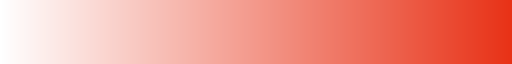

In [9]:
from types import new_class
from matplotlib.colors import LinearSegmentedColormap

# colors = ['#1f4fa1', '#ffffff', '#e83217']
colors = ['#ffffff', '#e83217']
n_bins = 256
new_cmap = LinearSegmentedColormap.from_list('custom_diverging', colors, N=n_bins)
new_cmap

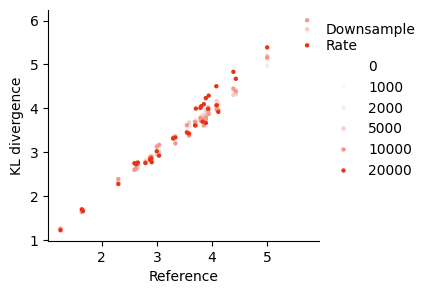

In [84]:
plt.figure(figsize=(3.5, 3))
sns.scatterplot(entro_data, x='Reference', y='KL divergence', hue='Downsample', palette=new_cmap, s=10,
                alpha=1, edgecolor='none')
# sns.regplot(entro_data, x='Reference', y='KL divergence', scatter=False, color='gray',
#             line_kws={'linestyle': '--'}, ci=None)
sns.despine()

# 计算R2
from sklearn.metrics import r2_score
r2 = r2_score(entro_data['Reference'], entro_data['KL divergence'])

# 在左上角添加R2标注
# plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, 
        #  bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.legend(title='Downsample\nRate', loc='upper right', bbox_to_anchor=(1.4, 1), frameon=False)

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('../20240822-Pipeline/supplementary_images/entropy_downsample.pdf', bbox_inches='tight')

plt.show()

In [16]:
fdata = sc.read_h5ad('/home/wpy/stereoseq/20240502-SPACseq/RNA/Multitime.clustered.clean.h5')
fdata

AnnData object with n_obs × n_vars = 118279 × 13177
    obs: 'marker', 'n_genes', 'n_counts', 'cluster_cellcharter_givenk'
    obsm: 'spatial'

In [5]:
def align_rna_guide_data(fdata, gdata):
    gdata.obs.marker = gdata.obs.marker.map({
        'B926-1': '2-1',
        'B926-2': '2-2',
        'B924-1': '1-1',
        'B924-2': '1-2',
        'B922-1': '3-1',
        'B922-2': '3-2'
    })
    fdata.obs['coord_x'] = fdata.obsm['spatial'][:, 0] // 100 * 100
    fdata.obs['coord_y'] = fdata.obsm['spatial'][:, 1] // 100 * 100

    gdata.obs['coord_x'] = gdata.obsm['spatial'][:, 0] // 100 * 100
    gdata.obs['coord_y'] = gdata.obsm['spatial'][:, 1] // 100 * 100

    gdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(gdata.obs['marker'], gdata.obs['coord_x'], gdata.obs['coord_y'])]
    fdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(fdata.obs['marker'], fdata.obs['coord_x'], fdata.obs['coord_y'])]

    common_bins = np.intersect1d(fdata.obs_names, gdata.obs_names)
    fdata = fdata[common_bins].copy()
    gdata = gdata[common_bins].copy()

    gdata.obs["cluster"] = fdata.obs["cluster_cellcharter_givenk"].tolist()
    return fdata, gdata
fdata, gdata = align_rna_guide_data(fdata, gdata)

In [12]:
gdata.obs['cluster'] = fdata.obs['cluster_cellcharter_givenk']
mdata = gdata[gdata.obs.marker == '2-1']

chi_dict = {}
for ds_size in [0, 1000, 2000, 5000, 10000, 20000]:

    chi_dict[ds_size] = {}
    print(mdata.X.sum(), end=' -> ')
    ds_bins = np.random.choice(mdata[mdata.X.sum(axis=1) > 0].obs_names, ds_size)
    dsdata = mdata.copy()
    dsdata[ds_bins].X = 0
    print(dsdata.X.sum())

    c_df = pd.concat([pd.DataFrame(dsdata.X, columns=dsdata.var_names, index=dsdata.obs_names), dsdata.obs["cluster"]], axis=1)
    c_df = c_df.groupby('cluster').sum()
    g_df = c_df.apply(lambda x: 10 ** (np.log10(x + 1) - (np.log10(x + 1).sum() / 12)), axis=1).T

    # c_df = c_df.div(c_df.sum(axis=0)) * c_df.loc[:, 'sgnon-targeting'].sum()

    # from scipy.stats import chi2_contingency
    from scipy.spatial.distance import euclidean
    # from tqdm import tqdm
    # for guide in tqdm(c_df.columns):
    #     if c_df.loc[:, guide].sum() < 10: continue
    #     observed = np.array([c_df.sum(axis=1).tolist(), c_df[guide].tolist()]).T
    #     chi_dict[ds_size][guide] = chi2_contingency(observed)[1]
    dist = g_df.apply(lambda x: euclidean(x, g_df.loc['sgnon-targeting']), axis=1).values
    for i, guide in enumerate(g_df.index):
        chi_dict[ds_size][guide] = dist[i]

16894 -> 16894
16894 -> 15270
16894 -> 13717
16894 -> 10233
16894 -> 

/tmp/ipykernel_32121/1028748389.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c_df = c_df.groupby('cluster').sum()
/tmp/ipykernel_32121/1028748389.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c_df = c_df.groupby('cluster').sum()
/tmp/ipykernel_32121/1028748389.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c_df = c_df.groupby('cluster').sum()
/tmp/ipykernel_32121/1028748389.py:15: FutureWarning: The 

6154
16894 -> 2311


/tmp/ipykernel_32121/1028748389.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c_df = c_df.groupby('cluster').sum()


In [13]:
entro_data = pd.DataFrame({
    'Downsample': [0] * len(chi_dict[0].keys()) + \
        [1000] * len(chi_dict[1000].keys()) + \
        [2000] * len(chi_dict[2000].keys()) + \
        [5000] * len(chi_dict[5000].keys()) + \
        [10000] * len(chi_dict[10000].keys()) + \
        [20000] * len(chi_dict[20000].keys()),
    'Entropy': [chi_dict[ds_size][i] for ds_size in [0, 1000, 2000, 5000, 10000, 20000] for i in chi_dict[ds_size].keys()],
    'Gene': [i for i in chi_dict[0].keys()] * 6,
    'Reference': [chi_dict[0][i] for i in chi_dict[0].keys()] * 6
})
# entro_data.Entropy = entro_data.Entropy.apply(lambda x: -np.log10(x))
# entro_data.Reference = entro_data.Reference.apply(lambda x: -np.log10(x))

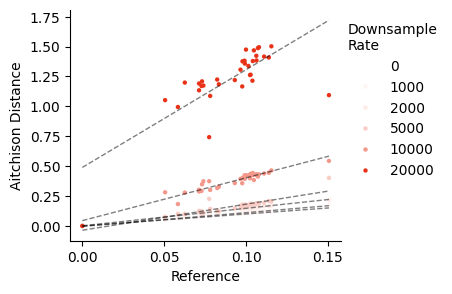

In [19]:
plt.figure(figsize=(3.5, 3))
sns.scatterplot(entro_data, x='Reference', y='Entropy', hue='Downsample', palette=new_cmap, s=10,
                alpha=1, edgecolor='none')
# sns.regplot(entro_data, x='Reference', y='Entropy', scatter=False, color='gray', line_kws={'linestyle': '--'}, ci=None,)
sns.despine()

# 计算R2
from sklearn.metrics import r2_score
r2 = r2_score(entro_data['Reference'], entro_data['Entropy'])

for i in entro_data.Downsample.unique():
    sns.regplot(entro_data[entro_data.Downsample == i], x='Reference', y='Entropy',
                scatter=False, color='black', line_kws={'linestyle': '--', 'linewidth': 1, 'alpha': 0.5}, ci=None,)

# 在左上角添加R2标注
# plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, 
        #  bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# for row in entro_data.index:
    # if entro_data.loc[row, 'Entropy'] > 1.5:
        # plt.text(entro_data.loc[row, 'Reference'], entro_data.loc[row, 'Entropy'], entro_data.loc[row, 'Gene'])

plt.legend(title='Downsample\nRate', loc='upper right', bbox_to_anchor=(1.4, 1), frameon=False)

plt.ylabel('Aitchison Distance')
# plt.ylim([-0.1, 1.1])

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('../20240822-Pipeline/supplementary_images/chi_downsample.pdf', bbox_inches='tight')

plt.show()

190659 -> 1748


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


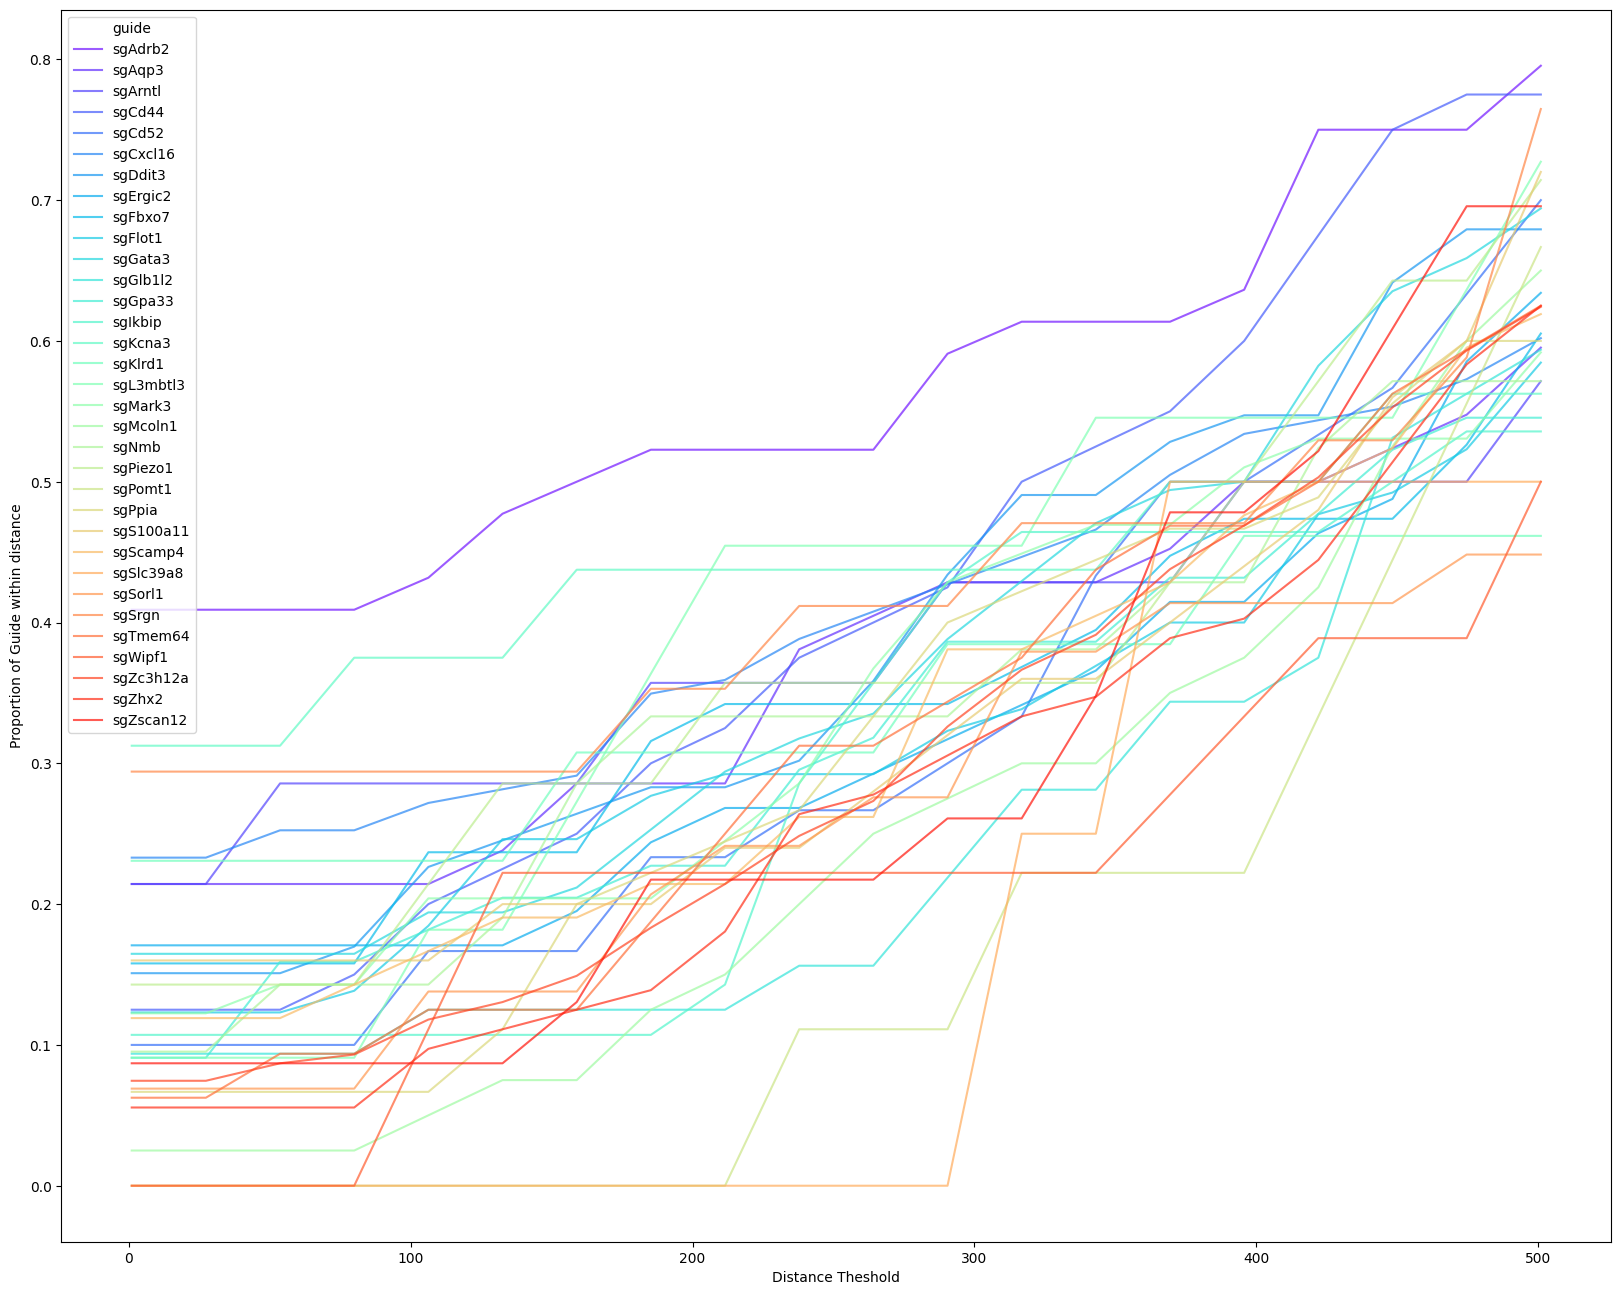

In [10]:
pdata = gdata[gdata.obs.marker == 'B926-2'].copy()
print(pdata.X.sum(), end=' -> ')
ds_size = 500000
ds_bins = np.random.choice(pdata[pdata.X.sum(axis=1) > 0].obs_names, ds_size)
dsdata = pdata.copy()
dsdata[ds_bins].X = 0
print(dsdata.X.sum())

from tqdm import tqdm
from scipy.spatial import distance_matrix

proportion_5 = {}
for threshold in tqdm(np.linspace(1, 501, 20)):
    proportion_5[threshold] = []
    for guide in dsdata.var_names:
        if guide == 'sgnon-targeting': continue
        guide_data = dsdata[dsdata[:, guide].X > 0]
        ntc_data = dsdata[dsdata[:, 'sgnon-targeting'].X > 0]
        in_distance = ((distance_matrix(guide_data.obsm['spatial'], ntc_data.obsm['spatial']) < threshold).sum(axis=1) > 0).sum()
        proportion_5[threshold].append(in_distance / guide_data.shape[0])

d_df = pd.DataFrame(proportion_5).melt()
d_df.index = dsdata[:, dsdata.var_names != 'sgnon-targeting'].var_names.tolist() * 20
d_df.reset_index(inplace=True)
plt.figure(figsize=(20, 16))
sns.lineplot(d_df, x='variable', y='value', hue='index', palette='rainbow', alpha=0.7)
plt.xlabel('Distance Theshold')
plt.ylabel('Proportion of Guide within distance')
plt.legend(title='guide')

/tmp/ipykernel_34332/3440522152.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)


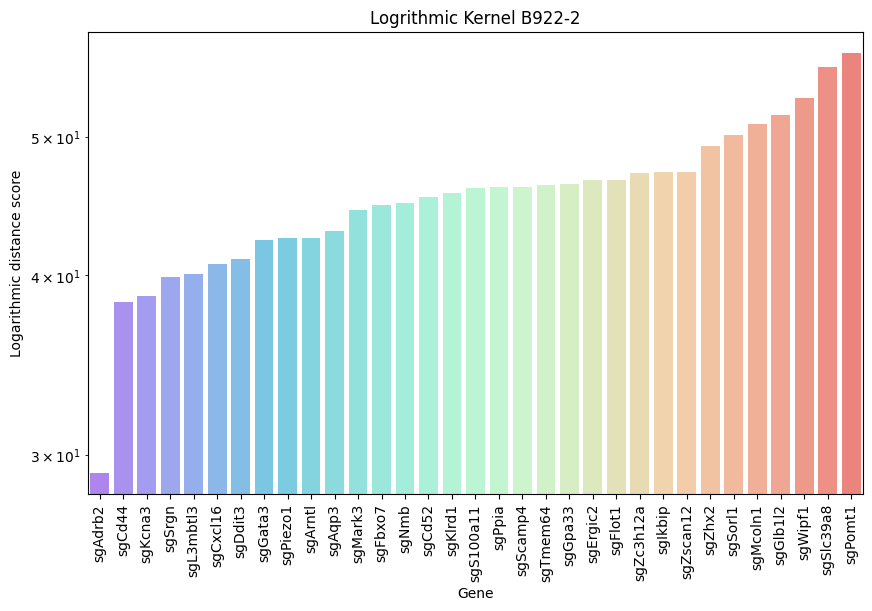

In [17]:
d_df = pd.DataFrame(proportion_5, index=gdata[:, gdata.var_names != 'sgnon-targeting'].var_names.tolist())
#d_df = pd.concat([d_df, pd.DataFrame(proportion_rand, index=['Random_20', '_', '_', '_', 'Random_10000']).iloc[[0, 4], :]], axis=0)

ln_scoring = np.array([np.log(x) for x in np.linspace(1, 100, 20)])

ln_sc = d_df.apply(lambda x: np.multiply(ln_scoring, 1-x), axis=1).sum(axis=1).sort_values()
ln_df = pd.DataFrame(ln_sc, columns=['ln_dist'])
ln_df['gene'] = ln_df.index.str.split('_').str.get(0).tolist()
ln_df.reset_index(inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(ln_df, y='ln_dist', x='gene', ax=ax, palette='rainbow', orient='v', alpha=0.6)
plt.xticks(rotation=90)
# plt.ylim(0,)
plt.gca().set_yscale('log')
plt.xlabel('Gene')
plt.ylabel('Logarithmic distance score')
plt.title('Logrithmic Kernel ' + 'B922-2')
plt.show()

/tmp/ipykernel_34332/3672247672.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(d_df, y='Permutation', x='Correlation', orient='h', palette='Blues')


Text(0.5, 1.0, 'Rank Correlation with Control B926-2')

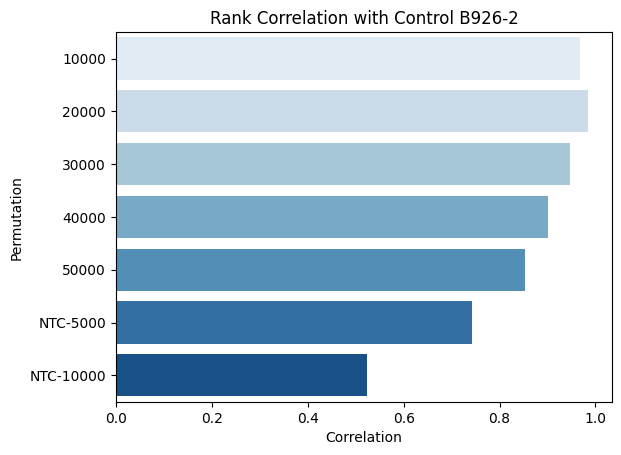

In [33]:
# Rank correlation
d_df = pd.DataFrame({
    'Permutation': ['10000', '20000', '30000', '40000', '50000', 'NTC-5000', 'NTC-10000'],
    'Correlation': [0.967, 0.985, 0.946, 0.901, 0.854, 0.742, 0.523]
})
sns.barplot(d_df, y='Permutation', x='Correlation', orient='h', palette='Blues')
plt.title('Rank Correlation with Control B926-2')

# Tumor downsample

In [2]:
meta_data = sc.read_h5ad("/data200T/SPACseq/HD/output/metastasis_samples_raw.h5ad")

In [3]:
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN

In [4]:
def cluster_by_DBSCAN(adata, guide, eps=5, min_samples=20):
    guide_adata = adata[adata.obs[guide]==1].copy()
    guide_dots = guide_adata.obs[["array_col","array_row"]]
    guide_dots = guide_dots.to_numpy()

    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(guide_dots)
    print("Number of Clusters (excluding noise):", len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0))

    cluster_labels = clustering.labels_
    guide_adata.obs["dbscan_cluster"] = "Noise"
    guide_adata.obs.loc[guide_adata.obs[guide] == 1, "dbscan_cluster"] = cluster_labels.astype(str)

    return guide_adata

def define_region(guide_adata, label="0", mode="most", density_level=7):
    labels = np.array(guide_adata.obs["dbscan_cluster"])

    if mode == "most":
        filtered_labels = labels[labels != "-1"]
        unique_labels, counts = np.unique(filtered_labels, return_counts=True)
        max_count_index = np.argmax(counts)
        label = unique_labels[max_count_index]

    guide_dots = guide_adata.obs[["array_col","array_row"]]
    guide_dots = guide_dots.to_numpy()
    cluster_points = guide_dots[labels == label]

    if cluster_points.size == 0:
        raise ValueError(f"No points found for label {label}. Function will terminate.")

    kde = gaussian_kde(cluster_points.T)

    x_min, x_max = cluster_points[:, 0].min() - 1, cluster_points[:, 0].max() + 1
    y_min, y_max = cluster_points[:, 1].min() - 1, cluster_points[:, 1].max() + 1
    x_range = np.arange(x_min, x_max + 1)
    y_range = np.arange(y_min, y_max + 1)
    X, Y = np.meshgrid(x_range, y_range)
    grid_coords = np.vstack([X.ravel(), Y.ravel()])

    Z = kde(grid_coords).reshape(X.shape)
    density_levels = np.linspace(Z.min(), Z.max(), density_level)
    level_density = density_levels[2]

    core_points_mask = Z >= level_density
    core_points = np.column_stack((X[core_points_mask], Y[core_points_mask]))

    core_points_df = pd.DataFrame(core_points, columns=['array_col', 'array_row'])

    return core_points_df

In [5]:
meta_data.obs['guide_count'] = meta_data[:, meta_data.var_names.str.startswith('sg')].X.toarray().sum(axis=1)
guide_data = cluster_by_DBSCAN(meta_data[meta_data.obs['sample'] == '992_1'], guide='guide_count')

Number of Clusters (excluding noise): 124


In [6]:
df = define_region(guide_data)

In [135]:
meta_data[meta_data.obs['sample'] == '992_1']

View of AnnData object with n_obs × n_vars = 488373 × 20573
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'guide_count'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [104]:
guide_data.obs.dbscan_cluster.unique()

array(['-1'], dtype=object)

In [7]:

sub_data = meta_data[meta_data.obs['sample'] == '992_1', meta_data.var_names.str.startswith('sg')]
sub_data

View of AnnData object with n_obs × n_vars = 488373 × 1520
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'guide_count'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [38]:
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

df_dict = {}
for ds_size in [5000, 10000, 20000, 50000]:
    print(sub_data.X.toarray().sum(), end=' -> ')
    ds_bins = np.random.choice(sub_data[sub_data.X.toarray().sum(axis=1) > 0].obs_names, ds_size)
    dsdata = sub_data.copy()
    dsdata[ds_bins].X = 0
    print(dsdata.X.toarray().sum())

    dsdata.obs['guide_count'] = dsdata[:, dsdata.var_names.str.startswith('sg')].X.toarray().sum(axis=1)
    guide_data = cluster_by_DBSCAN(dsdata, guide='guide_count')
    df_dict[ds_size] = pd.DataFrame()
    continue
    for label in tqdm(guide_data.obs.dbscan_cluster.unique()):
        if label == '-1': continue
        pdata = guide_data[guide_data.obs.dbscan_cluster == label].copy()
        df = define_region(pdata, label=label, mode='most').set_index(['array_col', 'array_row'])
        df['cluster'] = label
        df_dict[ds_size] = pd.concat([df_dict[ds_size], df], axis=0)

105822.0 -> 96564.0
Number of Clusters (excluding noise): 136
105822.0 -> 88581.0
Number of Clusters (excluding noise): 144
105822.0 -> 73695.0
Number of Clusters (excluding noise): 175
105822.0 -> 42919.0
Number of Clusters (excluding noise): 8


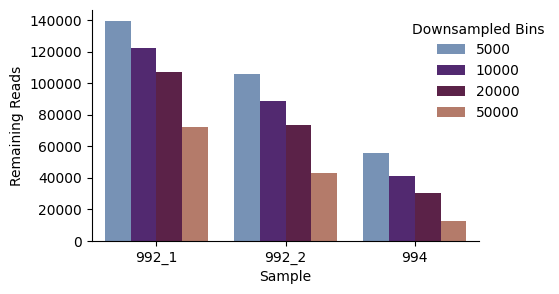

In [48]:
remaining_reads = {
    '992_1': [139628, 122451, 107127, 72475],
    '992_2': [105822, 88581, 73695, 42919],
    '994': [55461, 41054, 30382, 12656],
}
df = pd.DataFrame(remaining_reads)
df.index = ['5000', '10000', '20000', '50000']
# df.T.plot(kind='bar', stacked=True, figsize=(10, 6))
df = df.melt(ignore_index=False).reset_index()
df.columns = ['sample', 'Downsample', 'Remaining Reads']
plt.figure(figsize=(5, 3))
sns.barplot(df, x='Downsample', y='Remaining Reads', hue='sample', orient='v', palette='twilight')
sns.despine()
plt.xlabel('Sample')
plt.ylabel('Remaining Reads')
plt.legend(title='Downsampled Bins', loc='upper right', bbox_to_anchor=(1.2, 1), frameon=False)

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./supplementary_images/reads_downsample.pdf', bbox_inches='tight')
plt.show()

In [9]:
import pickle
# pickle.dump(df_dict, open('./downsample_data.994.pickle', 'wb'))

In [59]:
fdata = sc.read_h5ad("/data200T/SPACseq/HD/output/clones_with_labels.h5ad")
fdata = fdata[:, fdata.var_names.str.startswith('sg')]
fdata = fdata[fdata.X.toarray().sum(axis=1) > 0, :]

In [65]:
matrix_0 = np.zeros([int(fdata.obs.array_col.max()), int(fdata.obs.array_row.max())])
for col, row in zip(fdata.obs.array_col.tolist(), fdata.obs.array_row.tolist()):
    matrix_0[int(col) - 1, int(row) - 1] = 1

In [82]:
n_max = 837

In [83]:
matrix_5000 = np.zeros([n_max, n_max])
for row in df_dict[5000].iterrows():
    matrix_5000[int(row[0][0]) - 1, int(row[0][1]) - 1] = 1

In [84]:
matrix_10000 = np.zeros([n_max, n_max])
for row in df_dict[10000].iterrows():
    matrix_10000[int(row[0][0]) - 1, int(row[0][1]) - 1] = 1

In [85]:
matrix_20000 = np.zeros([n_max, n_max])
for row in df_dict[20000].iterrows():
    matrix_10000[int(row[0][0]) - 1, int(row[0][1]) - 1] = 1

In [86]:
matrix_50000 = np.zeros([n_max, n_max])
for row in df_dict[50000].iterrows():
    matrix_10000[int(row[0][0]) - 1, int(row[0][1]) - 1] = 1

In [10]:
df_dict = pickle.load(open('./downsample_data.922_1.pickle', 'rb'))

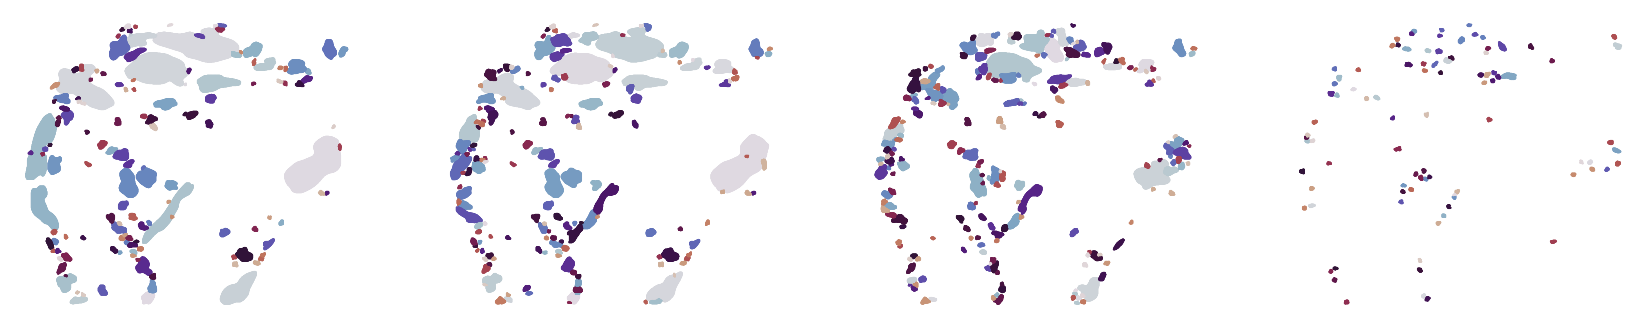

In [11]:
_, ax = plt.subplots(1, 4, figsize=(21, 4))
for i, ds_size in enumerate([5000, 10000, 20000, 50000]):
    sns.scatterplot(x=df_dict[ds_size].index.get_level_values(0), y=df_dict[ds_size].index.get_level_values(1),
                    hue=df_dict[ds_size]['cluster'], legend=False, s=1, edgecolor='none', palette='twilight', ax=ax[i])
    sns.despine(left=True, bottom=True, ax=ax[i])
    ax[i].invert_yaxis()
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')

plt.savefig('./supplementary_images/downsample_data.992_1.png', bbox_inches='tight', format='png', dpi=300)
plt.show()

In [14]:
import pickle
df_dict_1 = pickle.load(open('./downsample_data.922_1.pickle', 'rb'))
df_dict_2 = pickle.load(open('./downsample_data.922_2.pickle', 'rb'))
df_dict_3 = pickle.load(open('./downsample_data.994.pickle', 'rb'))

overlap = {}
for ds_size in [5000, 10000, 20000, 50000]:
    overlap[ds_size] = []
    print(ds_size)
    overlap[ds_size].append(2 * len(np.intersect1d(df_dict_1[ds_size].index, df_dict_1[5000].index)) / (len(df_dict_1[5000].index) + len(df_dict_1[ds_size].index)))
    overlap[ds_size].append(2 * len(np.intersect1d(df_dict_2[ds_size].index, df_dict_2[5000].index)) / (len(df_dict_2[5000].index) + len(df_dict_2[ds_size].index)))
    overlap[ds_size].append(2 * len(np.intersect1d(df_dict_3[ds_size].index, df_dict_3[5000].index)) / (len(df_dict_3[5000].index) + len(df_dict_3[ds_size].index)))
overlap = pd.DataFrame(overlap)
overlap.index = ['992_1', '992_2', '994']
overlap.columns = ['5000', '10000', '20000', '50000']

5000
10000
20000
50000


/tmp/ipykernel_13644/3325685468.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df, x='variable', y='value', orient='v', palette='twilight')


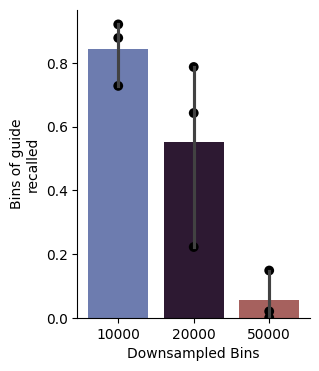

In [15]:
df = overlap.melt(ignore_index=False).reset_index()
df = df[df.variable != '5000']
plt.figure(figsize=(3, 4))

sns.barplot(df, x='variable', y='value', orient='v', palette='twilight')
sns.scatterplot(df, x='variable', y='value', color='black', s=50, edgecolor='none')

sns.despine()
plt.xlabel('Downsampled Bins')
plt.ylabel('Bins of guide\nrecalled')
# plt.title('Overlap Rate of Downsampled Regions')

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./supplementary_images/downsample_overlap.pdf', bbox_inches='tight')
plt.show()

In [87]:
from pytorch_msssim import ms_ssim, ssim
import torch
import scanpy as sc
import squidpy as sq
import matplotlib as mlp
from tqdm import tqdm

x_0 = torch.from_numpy(matrix_0).unsqueeze(0).unsqueeze(0)
x_5000 = torch.from_numpy(matrix_5000).unsqueeze(0).unsqueeze(0)
x_10000 = torch.from_numpy(matrix_10000).unsqueeze(0).unsqueeze(0)
x_20000 = torch.from_numpy(matrix_20000).unsqueeze(0).unsqueeze(0)
x_50000 = torch.from_numpy(matrix_50000).unsqueeze(0).unsqueeze(0)

ssim_matrix = np.zeros((5, 5))
ssim_matrix[0, 0] = ssim(x_0, x_0, data_range = 1, size_average=False).numpy()[0]
ssim_matrix[1, 1] = ssim(x_5000, x_5000, data_range = 1, size_average=False).numpy()[0]
ssim_matrix[2, 2] = ssim(x_10000, x_10000, data_range = 1, size_average=False).numpy()[0]
ssim_matrix[3, 3] = ssim(x_20000, x_20000, data_range = 1, size_average=False).numpy()[0]
ssim_matrix[4, 4] = ssim(x_50000, x_50000, data_range = 1, size_average=False).numpy()[0]
ssim_matrix[0, 1] = ssim(x_0, x_5000, data_range = 1, size_average=False).numpy()[0]
ssim_matrix[0, 2] = ssim(x_0, x_10000, data_range = 1, size_average=False).numpy()[0]
ssim_matrix[0, 3] = ssim(x_0, x_20000, data_range = 1, size_average=False).numpy()[0]
ssim_matrix[0, 4] = ssim(x_0, x_50000, data_range = 1, size_average=False).numpy()[0]
ssim_matrix[1, 2] = ssim(x_5000, x_10000, data_range = 1, size_average=False).numpy()[0]
ssim_matrix[1, 3] = ssim(x_5000, x_20000, data_range = 1, size_average=False).numpy()[0]
ssim_matrix[1, 4] = ssim(x_5000, x_50000, data_range = 1, size_average=False).numpy()[0]
ssim_matrix[2, 3] = ssim(x_10000, x_20000, data_range = 1, size_average=False).numpy()[0]
ssim_matrix[2, 4] = ssim(x_10000, x_50000, data_range = 1, size_average=False).numpy()[0]
ssim_matrix[3, 4] = ssim(x_20000, x_50000, data_range = 1, size_average=False).numpy()[0]

<Axes: >

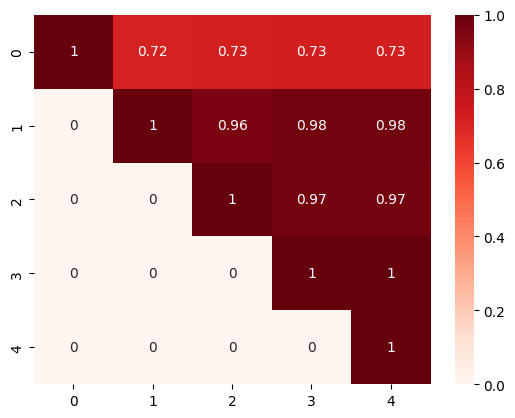

In [90]:
sns.heatmap(ssim_matrix, annot=True, cmap='Reds')

In [ ]:
gdata.obs['cluster'] = fdata.obs['cluster_cellcharter_givenk']
mdata = gdata[gdata.obs.marker == '2-1']

chi_dict = {}
for ds_size in [0, 1000, 2000, 5000, 10000, 20000]:

    chi_dict[ds_size] = {}
    print(mdata.X.sum(), end=' -> ')
    ds_bins = np.random.choice(mdata[mdata.X.sum(axis=1) > 0].obs_names, ds_size)
    dsdata = mdata.copy()
    dsdata[ds_bins].X = 0
    print(dsdata.X.sum())

    c_df = pd.concat([pd.DataFrame(dsdata.X, columns=dsdata.var_names, index=dsdata.obs_names), dsdata.obs["cluster"]], axis=1)
    c_df = c_df.groupby('cluster').sum()
    g_df = c_df.apply(lambda x: 10 ** (np.log10(x + 1) - (np.log10(x + 1).sum() / 12)), axis=1).T

    # c_df = c_df.div(c_df.sum(axis=0)) * c_df.loc[:, 'sgnon-targeting'].sum()

    # from scipy.stats import chi2_contingency
    from scipy.spatial.distance import euclidean
    # from tqdm import tqdm
    # for guide in tqdm(c_df.columns):
    #     if c_df.loc[:, guide].sum() < 10: continue
    #     observed = np.array([c_df.sum(axis=1).tolist(), c_df[guide].tolist()]).T
    #     chi_dict[ds_size][guide] = chi2_contingency(observed)[1]
    dist = g_df.apply(lambda x: euclidean(x, g_df.loc['sgnon-targeting']), axis=1).values
    for i, guide in enumerate(g_df.index):
        chi_dict[ds_size][guide] = dist[i]

In [138]:
df.set_index(['array_col', 'array_row'])

,
array_col,array_row
496.0,3.0
497.0,3.0
498.0,3.0
499.0,3.0
500.0,3.0
...,...
470.0,113.0
471.0,113.0
472.0,113.0


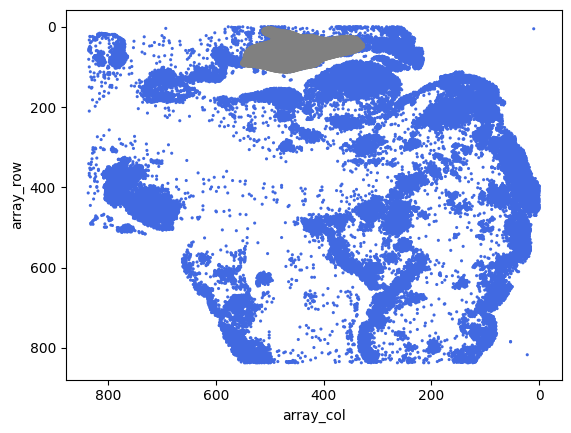

In [133]:
sns.scatterplot(x=guide_data.obs['array_col'], y=guide_data.obs['array_row'], c='royalblue', edgecolor='none', s=5)
sns.scatterplot(x=df['array_col'], y=df['array_row'], c='gray', edgecolor='none', s=5)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# Cluster downsampling

In [4]:
fdata = sc.read_h5ad('/home/wpy/stereoseq/20240502-SPACseq/RNA/B926-1.expr.bin_100.h5')
fdata = utils.remove_mito_ribo_hk_lnc_genes(fdata)
sc.pp.filter_cells(fdata, min_genes=3)
sc.pp.filter_genes(fdata, min_cells=3)
del fdata.var

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [24]:
downsample_rate = 1
down_fdata = fdata.copy()
# 随机生成0.8-1之间的系数矩阵
random_factors = np.random.normal(downsample_rate, 0.3, size=down_fdata.X.shape).clip(0, 1)

# 将系数矩阵与原始数据相乘
down_fdata.X = down_fdata.X.multiply(random_factors)
down_fdata.X = down_fdata.X.astype(int)

print(down_fdata.X.sum() / fdata.X.sum())

down_fdata.X = down_fdata.X.toarray()
down_fdata.write_h5ad('/home/wpy/stereoseq/20240502-SPACseq/RNA/B926-1.downsample_1.h5')

0.7473216549916469


In [26]:
downsample_rate = 0.8
down_fdata = fdata.copy()
# 随机生成0.8-1之间的系数矩阵
random_factors = np.random.normal(downsample_rate, 0.3, size=down_fdata.X.shape).clip(0, 1)

# 将系数矩阵与原始数据相乘
down_fdata.X = down_fdata.X.multiply(random_factors)
down_fdata.X = down_fdata.X.astype(int)

print(down_fdata.X.sum() / fdata.X.sum())

down_fdata.X = down_fdata.X.toarray()
down_fdata.write_h5ad('/home/wpy/stereoseq/20240502-SPACseq/RNA/B926-1.downsample_2.h5')

0.576257029865672


In [5]:
downsample_rate = 1.2
down_fdata = fdata.copy()
# 随机生成0.8-1之间的系数矩阵
random_factors = np.random.normal(downsample_rate, 0.3, size=down_fdata.X.shape).clip(0, 1)

# 将系数矩阵与原始数据相乘
down_fdata.X = down_fdata.X.multiply(random_factors)
down_fdata.X = down_fdata.X.astype(int)

print(down_fdata.X.sum() / fdata.X.sum())

down_fdata.X = down_fdata.X.toarray()
down_fdata.write_h5ad('/home/wpy/stereoseq/20240502-SPACseq/RNA/B926-1.downsample_3.h5')

0.8822243861555967
